Plan działania:

1. Klasteryzacja sklepów - Hubert
2. Badanie zbioru + budowa modeli
2.1 XGBoost Regresor - Hubert
2.2 Random Forest Regresor - Błażej
2.2. SVM - Jonasz 
2.3. Preprocessing datasetu
3. Sieci rekurencyjne - szeregi czasowe - budowa sieci Jonasz/Błażej/Hubert
4. Prezentacja 
4.1 Szablon - Hubert
4.2 Uzupełnienie wartości merytorycznej Jonasz/Błażej/Hubert 
5. Aplikacja - Angelika

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("Walmart.csv")

In [4]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [6]:
df.sort_values("Date", ascending=False)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
4623,33,31-12-2010,219804.85,1,52.91,3.148,127.087677,9.265
2335,17,31-12-2010,635862.55,1,20.79,2.868,127.087677,6.885
1906,14,31-12-2010,1623716.46,1,29.67,3.179,182.571448,8.724
3479,25,31-12-2010,623092.54,1,25.89,3.179,204.643227,7.484
5624,40,31-12-2010,811318.30,1,19.29,3.177,132.815032,5.287
...,...,...,...,...,...,...,...,...
632,5,01-04-2011,314316.55,0,61.50,3.524,215.402441,6.489
2062,15,01-04-2011,542556.05,0,30.34,3.811,134.068258,7.658
1061,8,01-04-2011,878762.30,0,49.86,3.524,218.258628,6.297
4493,32,01-04-2011,1051121.02,0,44.83,3.461,192.269171,8.595


In [7]:
df.shape

(6435, 8)

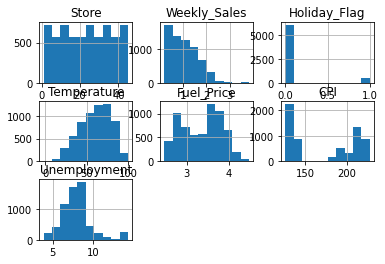

In [8]:
df.hist()
pass

In [9]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [10]:
data = df["Weekly_Sales"].to_numpy().reshape(-1,1)

In [11]:
km = KMeans(n_clusters=3, max_iter = 100, n_init=10)
km.fit(data)
df["cluster_sklearn"] = km.labels_

In [12]:
df["cluster_sklearn"].unique()

array([1, 0, 2])

In [13]:
class_0 = df[df["cluster_sklearn"] == 0]
class_0

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,cluster_sklearn
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,0
5,1,12-03-2010,1439541.59,0,57.79,2.667,211.380643,8.106,0
6,1,19-03-2010,1472515.79,0,54.58,2.720,211.215635,8.106,0
7,1,26-03-2010,1404429.92,0,51.45,2.732,211.018042,8.106,0
10,1,16-04-2010,1466058.28,0,66.32,2.808,210.488700,7.808,0
...,...,...,...,...,...,...,...,...,...
6390,45,23-12-2011,1521957.99,0,42.27,3.389,188.929975,8.523,0
6391,45,30-12-2011,869403.63,1,37.79,3.389,189.062016,8.523,0
6398,45,17-02-2012,858853.75,0,36.85,3.695,189.842483,8.424,0
6405,45,06-04-2012,899479.43,0,49.73,3.996,190.685171,8.567,0


In [14]:
class_1 = df[df["cluster_sklearn"] == 1]
class_1

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,cluster_sklearn
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,1
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,1
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,1
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,1
8,1,02-04-2010,1594968.28,0,62.27,2.719,210.820450,7.808,1
...,...,...,...,...,...,...,...,...,...
5816,41,09-12-2011,1548661.45,0,17.05,3.331,195.874257,6.759,1
5817,41,16-12-2011,1682368.32,0,25.01,3.266,195.984169,6.759,1
5818,41,23-12-2011,2263722.68,0,25.59,3.173,196.171389,6.759,1
5852,41,17-08-2012,1560590.05,0,65.77,3.545,198.100106,6.432,1


In [15]:
class_2 = df[df["cluster_sklearn"] == 2]
class_2

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,cluster_sklearn
286,3,05-02-2010,461622.22,0,45.71,2.572,214.424881,7.368,2
287,3,12-02-2010,420728.96,1,47.93,2.548,214.574792,7.368,2
288,3,19-02-2010,421642.19,0,47.07,2.514,214.619887,7.368,2
289,3,26-02-2010,407204.86,0,52.05,2.561,214.647513,7.368,2
290,3,05-03-2010,415202.04,0,53.04,2.625,214.675139,7.368,2
...,...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684,2
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667,2
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667,2
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667,2


In [16]:
print(np.max(class_1["Weekly_Sales"]))
print(np.min(class_1["Weekly_Sales"]))
print(class_1.shape[0])

3818686.45
1543947.23
1270


In [17]:
print(np.max(class_0["Weekly_Sales"]))
print(np.min(class_0["Weekly_Sales"]))
print(class_0.shape[0])

1543678.02
841889.08
2484


In [18]:
print(np.max(class_2["Weekly_Sales"]))
print(np.min(class_2["Weekly_Sales"]))
print(class_2.shape[0])

841778.34
209986.25
2681


In [ ]:
file_name = "Walmart_klasy.csv"
df.to_csv(file_name)


In [ ]:
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,cluster_sklearn
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,1
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,1
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,1
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,0
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,1


In [ ]:
data_2 = df[["Store", "Weekly_Sales"]]

In [ ]:
km = KMeans(n_clusters=3, max_iter = 100, n_init=10)
km.fit(data_2)
df["cluster_sklearn"] = km.labels_

In [ ]:
df

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,cluster_sklearn
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,1
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,1
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,1
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,0
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,1
...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,2
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,2
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,2
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,2


In [ ]:
df_Store_1 = df[df["Store"] == 1]

NameError: name 'df' is not defined

In [ ]:
file_name = "Walmart_Store_1.xlsx"
df.to_csv(file_name)